In [77]:
import numpy as np
import scipy.io
import pandas as pd
import json
from typing import List, Callable
import run_classifiers
import matplotlib.pyplot as plt
from tqdm import tqdm
import neuroCombat

corrs_location = '../corrs'
A_mats_location = '../A_mats'

participants = pd.read_table('../SRPBS_OPEN/participants.tsv')
participants = participants.dropna()

train_sites = ['COI','KUT','SWA','UTO']
test_sites = ['ATT','ATV','CIN','HKH','HRC','HUH','KTT']

In [6]:
def participant_id_to_number(participant_id: str) -> int:
    return int(participant_id.split('-')[1])

def extract_participants_id(participants: pd.DataFrame, id: int) -> pd.DataFrame:
	return participants[[participant_id_to_number(name) == id for name in participants.participant_id.to_numpy()]]

def unpair(pairs: List[List[int]]) -> List[int]:
	return [id for pair in pairs for id in pair]

* 2 types of data (A matrices or correlations)
* 2 outlier choices (remove or not)
* 3 dataset subsets (all data, all pairs, perfect pairs)

In total - we have 2x2x3 = 12 datasets to feed into the classifiers

In [7]:
with open('../Dataset Analysis/dataset_all.txt','r') as f:
	ids_all_all = np.array(json.loads(f.read()))
with open('../Dataset Analysis/dataset_inliers.txt','r') as f:
	ids_inliers_all = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_pairs.txt','r') as f:
	ids_all_pairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_inliers_pairs.txt','r') as f:
	ids_inliers_pairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_perfect_pairs.txt','r') as f:
	ids_all_perfectpairs = np.array(json.loads(f.read()))
with open('../Dataset Analysis/all_inliers_perfect_pairs.txt','r') as f:
	ids_inliers_perfectpairs = np.array(json.loads(f.read()))

dataset_types = {
	'all': ids_all_all, 
	'inliers': ids_inliers_all, 
	# 'all_pairs': ids_all_pairs,
	# 'inliers_pairs': ids_inliers_pairs, 
	# 'all_perfectpairs': ids_all_perfectpairs, 
	# 'inliers_perfectpairs': ids_inliers_perfectpairs
}

In [8]:
def read_correlation(subject: int) -> np.ndarray:
	return np.nan_to_num(scipy.io.loadmat(f'{corrs_location}/correlation_components_{subject:04d}.mat')['corr_components'].reshape(1,-1))

def read_A_matrix(subject: int) -> np.ndarray:
	return scipy.io.loadmat(f'{A_mats_location}/dcm_A_{subject:04d}.mat')['A'].reshape(1,-1)

load_data_functions = {'corr': read_correlation, 'Amat': read_A_matrix}

In [84]:
def harmonise_data(X_train, X_test, ids_train, ids_test, participant_data):
    #protocol
    protocol_train = [int(participant.protocol.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    protocol_test = [int(participant.protocol.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]
    #age
    age_train = [int(participant.age.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    age_test = [int(participant.age.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]
    #sex
    sex_train = [int(participant.sex.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    sex_test = [int(participant.sex.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]
    #hand
    hand_train = [int(participant.hand.to_numpy()) for participant, is_train in zip(participant_data, ids_train) if is_train]
    hand_test = [int(participant.hand.to_numpy()) for participant, is_test in zip(participant_data, ids_test) if is_test]

    covars = pd.DataFrame(np.array([protocol_train+protocol_test, age_train+age_test, sex_train+sex_test, hand_train+hand_test]).T, columns=['protocol', 'age', 'sex', 'hand'])
    X = np.vstack((X_train, X_test))

    harmonised_result = neuroCombat.neuroCombat(X.T, covars, batch_col='protocol', categorical_cols=['sex','hand'], continuous_cols=['age'])
    #protocols_test = np.array(protocol_, dtype='object')[:,0] # need this to make it the right format...
    #harmonised_result_test = neuroCombat.neuroCombatFromTraining(X_test.T, protocol_test, harmonised_result['estimates'])

    X_train = harmonised_result['data'][:, ids_train].T
    X_test = harmonised_result['data'][:, ids_test].T

    return X_train, X_test

In [85]:
def load_dataset(ids: np.ndarray, load_data_function: Callable[[int], np.ndarray], harmonise=True):#, harmonise: True):
	if ids.ndim == 1: # single list of participants
		participant_data = [extract_participants_id(participants, id) for id in ids]
	else: # pairs of participants
		participant_data = [extract_participants_id(participants, id) for pair in ids for id in pair]
		ids = ids.flatten()
	participants_train = [participant.site.to_numpy() in train_sites for participant in participant_data]
	participants_test = [participant.site.to_numpy() in test_sites for participant in participant_data]
	X_train = np.vstack([load_data_function(id) for id in ids[participants_train]])
	X_test = np.vstack([load_data_function(id) for id in ids[participants_test]])
	
	if harmonise:
		X_train, X_test = harmonise_data(X_train, X_test, participants_train, participants_test, participant_data)

	labels = np.array(list(map(lambda participant: int(participant.diag // 2), participant_data)))
	Y_train = labels[participants_train]
	Y_test = labels[participants_test]

	return X_train, X_test, Y_train, Y_test

In [86]:
datasets = []

for dataset_name, ids in tqdm(dataset_types.items()):
	for function_name, load_data_function in load_data_functions.items():
		datasets.append([f'{dataset_name}_{function_name}', *load_dataset(ids, load_data_function)])




















  0%|          | 0/2 [00:00<?, ?it/s][neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data



















 50%|█████     | 1/2 [04:29<04:29, 269.75s/it][neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of 

In [87]:
for dataset in datasets:
	train_proportion = 100*dataset[3].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	test_proportion = 100*dataset[4].shape[0]/(dataset[3].shape[0] + dataset[4].shape[0])
	print(f'{dataset[0]}: (total - {dataset[3].shape[0] + dataset[4].shape[0]})\n\ttrain - [X: {dataset[1].shape}, Y: {dataset[3].shape}] ({train_proportion:.1f}%)\n\ttest -  [X: {dataset[2].shape}, Y: {dataset[4].shape}] ({test_proportion:.1f}%)')
for dataset_name, ids in dataset_types.items():
	print(f'{dataset_name} has {ids.size} participants')

all_corr: (total - 1043)
	train - [X: (626, 70876), Y: (626,)] (60.0%)
	test -  [X: (417, 70876), Y: (417,)] (40.0%)
all_Amat: (total - 1043)
	train - [X: (626, 142129), Y: (626,)] (60.0%)
	test -  [X: (417, 142129), Y: (417,)] (40.0%)
inliers_corr: (total - 994)
	train - [X: (589, 70876), Y: (589,)] (59.3%)
	test -  [X: (405, 70876), Y: (405,)] (40.7%)
inliers_Amat: (total - 994)
	train - [X: (589, 142129), Y: (589,)] (59.3%)
	test -  [X: (405, 142129), Y: (405,)] (40.7%)
all has 1043 participants
inliers has 994 participants


In [88]:
scores = run_classifiers.run_classifiers([datasets[0]])
np.save('100_classifier_scores', scores)

5128205128205], best alpha = 1.0
Running subsample 2
alpha validation scores = [0.3927350427350427, 0.41595441595441596, 0.435042735042735, 0.46566951566951564], best alpha = 1.0
Running subsample 3
alpha validation scores = [0.4160968660968661, 0.4279202279202279, 0.4202279202279202, 0.41951566951566954], best alpha = 0.01
Running subsample 4
alpha validation scores = [0.42378917378917375, 0.4235042735042735, 0.4616809116809117, 0.48091168091168085], best alpha = 1.0
Running subsample 5
alpha validation scores = [0.41239316239316237, 0.40441595441595446, 0.40071225071225075, 0.42037037037037034], best alpha = 1.0
Running subsample 6
alpha validation scores = [0.4547008547008547, 0.48575498575498577, 0.4739316239316239, 0.5044159544159544], best alpha = 1.0
Running subsample 7
alpha validation scores = [0.43903133903133906, 0.39316239316239315, 0.3933048433048433, 0.43903133903133906], best alpha = 0.001
Running subsample 8
alpha validation scores = [0.3893162393162393, 0.4159544159544

In [89]:
scores_df = pd.DataFrame(scores)
scores_df

,all_corr
Lasso_cv Testing Accuracy,0.402878
Lasso_cv Testing Balanced Accuracy,0.441106
Lasso_cv Testing F1 Score,0.306407
Lasso_cv Training Accuracy,0.554313
Lasso_cv Training Balanced Accuracy,0.709375
Lasso_cv Training F1 Score,0.511384


In [90]:
scores_df.filter(regex='.*Testing Balanced.*', axis='index')

,all_corr
Lasso_cv Testing Balanced Accuracy,0.441106


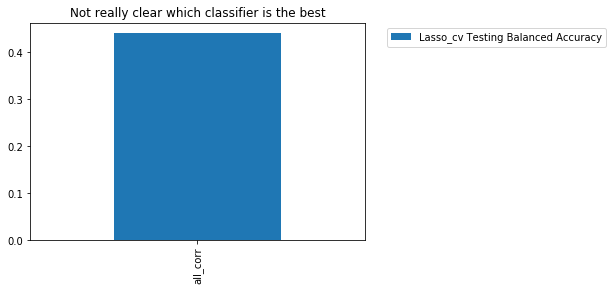

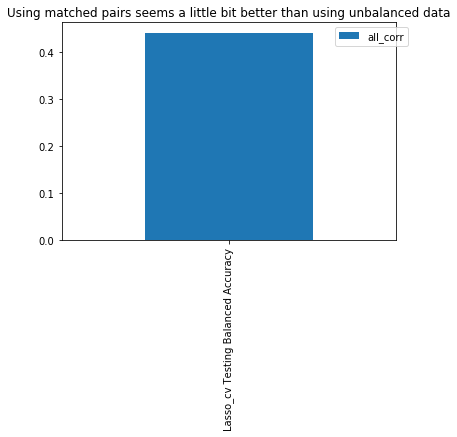

In [91]:
scores_df.filter(regex='.*Testing Balanced.*', axis='index').T.plot(kind='bar')
plt.title('Not really clear which classifier is the best')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

scores_df.filter(regex='.*Testing Balanced.*', axis='index').plot(kind='bar')
plt.title('Using matched pairs seems a little bit better than using unbalanced data')
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()